# Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
from os import path
import warnings
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import altair as alt
from sklearn.decomposition import PCA

from utils.load_data import read_online_proms_data, downcast, structure_name, get_meta, clean_data
from utils.data_dictionary import methods

# Step 2: Load data

In [2]:
# from https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/patient-reported-outcome-measures-proms
URL_PROMS_DATA = [
    r"https://files.digital.nhs.uk/6C/A1D581/CSV%20Data%20Pack%202016-17%20Finalised.zip",
    r"https://files.digital.nhs.uk/70/5176AA/CSV%20Data%20Pack%20Final%201718.zip",
    r"https://files.digital.nhs.uk/52/A8FF7F/PROMs%20CSV%20Data%20Pack%20Finalised%202018-19.zip",
    r"https://files.digital.nhs.uk/1F/51FEDE/PROMs%20CSV%20Data%20Pack%20Provisional%201920.zip",
]

DATA_PATH = "/data"

PART = "knee"
ORG = "provider"

In [3]:
%%time

# define path location
file_name = f"{PART}-{ORG}.parquet"
full_path = path.join(DATA_PATH, file_name)

# load from disk if present,
# otherwise get it directly from NHS-source + rename columns + save to parquet
if path.isfile(full_path):
    df_raw = pd.read_parquet(full_path)
else:
    df_raw = read_online_proms_data(urls=URL_PROMS_DATA, part=PART, org=ORG).apply(downcast)
    df_raw.columns = (
        df_raw.columns.str.replace("Pre-Op Q", "t0")
        .str.replace("Post-Op Q", "t1")
        .str.replace("Knee Replacement", "oks")
        .str.replace("Hip Replacement", "ohs")
        .str.replace("-", "_")
        .str.replace(" ", "_")
        .str.lower()
    )
    #df_raw.to_parquet(full_path)

# display basic info df_raw    
df_raw.info(verbose=False)

loaded Knee Replacement Provider 1617.csv from https://files.digital.nhs.uk/6C/A1D581/CSV%20Data%20Pack%202016-17%20Finalised.zip.
loaded Knee Replacements Provider 1718.csv from https://files.digital.nhs.uk/70/5176AA/CSV%20Data%20Pack%20Final%201718.zip.
loaded Knee Replacement Provider 1819.csv from https://files.digital.nhs.uk/52/A8FF7F/PROMs%20CSV%20Data%20Pack%20Finalised%202018-19.zip.
loaded Knee replacement provider 1920.csv from https://files.digital.nhs.uk/1F/51FEDE/PROMs%20CSV%20Data%20Pack%20Provisional%201920.zip.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 163833 entries, 0 to 24596
Columns: 81 entries, provider_code to oks_oks_t1_predicted
dtypes: category(4), float32(8), uint16(2), uint32(2), uint8(65)
memory usage: 19.1 MB
Wall time: 5.66 s


# Step 3: Basic cleaning

In [4]:
%%time
# restructure names
df_raw.columns = [structure_name(col) for col in df_raw.columns]

# construct a meta data df
df_meta = get_meta(df_raw.columns)  

# clean the data based on meta (all not in range, labels or label "missing")
df_clean = clean_data(df_raw, df_meta).apply(downcast)

# raise warning if somewhere there is a hidden 9 as max
if (df_clean.describe(include="all").loc["max"]==9).any():
    to_check = list(df_clean.loc[:, df_clean.describe(include="all").loc["max"]==9].columns)
    warning.warn("Please check the folowing columns for meta data:")
    display(to_check)
    
df_clean.sample(3)

Wall time: 3.9 s


,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
28131,RKB,Knee Replacement,0.0,2016/17,80 to 89,1.0,1.0,NaN,4.0,2.0,...,4.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,35.0,29.227633
4681,NT225,Knee Replacement,0.0,2018/19,50 to 59,2.0,2.0,NaN,3.0,2.0,...,3.0,3.0,3.0,0.0,3.0,3.0,4.0,3.0,32.0,35.474922
25460,RJF,Knee Replacement,0.0,2017/18,60 to 69,1.0,2.0,NaN,2.0,2.0,...,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,45.0,38.472843


# Step 4: Drop devisions of last year and NaN

In [5]:
df_eda = df_clean.query("t0_revision_flag == 0 & t0_year != '2019/20'")\
                 .drop(columns="t0_revision_flag")
df_eda["t0_year"].unique()

['2016/17', '2017/18', '2018/19']
Categories (3, object): ['2016/17', '2017/18', '2018/19']

In [30]:
# Change NaN in comoribidties to 1

comorbidities = ['t0_heart_disease','t0_high_bp','t0_stroke','t0_circulation','t0_lung_disease','t0_diabetes','t0_kidney_disease',
              't0_nervous_system','t0_liver_disease','t0_cancer','t0_depression','t0_arthritis']

df_pca = df_eda

df_pca[comorbidities] = df_pca[comorbidities].replace(np.nan, 2.0)

print(df_pca[comorbidities].isnull().sum().sum())

0


In [14]:
df_pca[comorbidities]

,t0_heart_disease,t0_high_bp,t0_stroke,t0_circulation,t0_lung_disease,t0_diabetes,t0_kidney_disease,t0_nervous_system,t0_liver_disease,t0_cancer,t0_depression,t0_arthritis
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
45630,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45631,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
45632,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
45633,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 5: Simple descriptives

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133962 entries, 0 to 45634
Data columns (total 80 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   t0_provider_code        133962 non-null  category
 1   t0_procedure            133962 non-null  category
 2   t0_year                 133962 non-null  category
 3   t0_age_band             124839 non-null  category
 4   t0_gender               124839 non-null  float32 
 5   t0_assisted             132505 non-null  float32 
 6   t0_assisted_by          0 non-null       float32 
 7   t0_symptom_period       132834 non-null  float32 
 8   t0_previous_surgery     132976 non-null  float32 
 9   t0_living_arrangements  131963 non-null  float32 
 10  t0_disability           128293 non-null  float32 
 11  t0_heart_disease        12463 non-null   float32 
 12  t0_high_bp              59267 non-null   float32 
 13  t0_stroke               2221 non-null    float32 
 14  t0_ci

In [9]:
pd.set_option("display.max.columns", None)
df_eda.head()

,t0_provider_code,t0_procedure,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,t0_circulation,t0_lung_disease,t0_diabetes,t0_kidney_disease,t0_nervous_system,t0_liver_disease,t0_cancer,t0_depression,t0_arthritis,t0_eq5d_mobility,t0_eq5d_self_care,t0_eq5d_activity,t0_eq5d_discomfort,t0_eq5d_anxiety,t0_eq5d_profile,t0_eq5d_score,t1_assisted,t1_assisted_by,t1_living_arrangements,t1_disability,t1_eq5d_mobility,t1_eq5d_self_care,t1_eq5d_activity,t1_eq5d_discomfort,t1_eq5d_anxiety,t1_satisfaction,t1_success,t1_allergy,t1_bleeding,t1_wound,t1_urine,t1_further_surgery,t1_readmitted,t1_eq5d_profile,t1_eq5d_score,t1_eq5d_predicted,t0_eqvas_score,t1_eqvas_score,t1_eqvas_predicted,t0_oks_pain,t0_oks_night_pain,t0_oks_washing,t0_oks_transport,t0_oks_walking,t0_oks_standing,t0_oks_limping,t0_oks_kneeling,t0_oks_work,t0_oks_confidence,t0_oks_shopping,t0_oks_stairs,t0_oks_score,t1_oks_pain,t1_oks_night_pain,t1_oks_washing,t1_oks_transport,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
0,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,4.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,2.0,2.0,3.0,2.0,22232.0,-0.016,2.0,NaN,2.0,1.0,2.0,NaN,2.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,63.0,50.0,59.824261,0.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0,15.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,3.0,1.0,3.0,2.0,29.0,28.123755
1,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,2.0,3.0,2.0,2.0,22322.0,0.189,2.0,NaN,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,11222.0,0.689,0.669850,30.0,58.0,64.729790,3.0,2.0,4.0,3.0,4.0,3.0,1.0,1.0,1.0,3.0,2.0,3.0,30.0,4.0,1.0,3.0,2.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,39.0,39.592751
2,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,2.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,3.0,3.0,1.0,21331.0,0.101,2.0,NaN,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,11111.0,1.000,0.785744,65.0,80.0,77.919701,0.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,2.0,3.0,24.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,45.0,40.250790
3,ADP02,Knee Replacement,2016/17,NaN,NaN,2.0,NaN,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,2.0,2.0,1.0,21221.0,0.691,2.0,NaN,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,11121.0,0.796,0.791476,90.0,90.0,79.585449,1.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,2.0,0.0,3.0,3.0,27.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,43.0,37.896225
4,ADP02,Knee Replacement,2016/17,NaN,NaN,1.0,NaN,3.0,2.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,2.0,2.0,1.0,21221.0,0.691,2.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,21221.0,0.691,0.816380,95.0,NaN,NaN,1.0,4.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,3.0,2.0,4.0,32.0,3.0,4.0,4.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,2.0,3.0,36.0,40.142567


# Step 6: Feature selection methods

In [21]:
# Start with EQ5D 

features = ['t0_eq5d_mobility','t0_eq5d_self_care','t0_eq5d_activity','t0_eq5d_discomfort','t0_eq5d_anxiety','t0_eqvas_score',
           't0_oks_pain','t0_oks_night_pain','t0_oks_washing','t0_oks_transport','t0_oks_walking','t0_oks_standing',
            't0_oks_limping','t0_oks_kneeling','t0_oks_shopping','t0_oks_stairs','t0_oks_score']

outcome = ['t1_eq5d_score']

# Separating out the features
x = df_pca.loc[:, features].values

# Separating out the target
y = df_pca.loc[:,outcome].values

## Step 6a: Removing features with low variance

In [82]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x)
X_new_1 = sel.fit_transform(x)
X_new_1.shape

(133962, 16)

## Step 6b: Feature selection using SelectFromModel

In [57]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

df_pca_na = df_pca.replace(np.nan, 9.0)  

# Make y a category
category = pd.cut(df_pca_na.t1_eq5d_score, bins=[-1.000,0.000,1.000], labels=['Poor','Good'])
df_pca_na.insert(49,'t1_eq5d_cat',category)

#df_pca_na['t1_eq5d_cat'] = df_pca_na['t1_eq5d_cat'].dropna()
#df_pca_na.info()
df_pca_na = df_pca_na.dropna(subset=['t1_eq5d_cat'])

In [51]:
df_pca_na.head()

,t0_provider_code,t0_procedure,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,t0_circulation,t0_lung_disease,t0_diabetes,t0_kidney_disease,t0_nervous_system,t0_liver_disease,t0_cancer,t0_depression,t0_arthritis,t0_eq5d_mobility,t0_eq5d_self_care,t0_eq5d_activity,t0_eq5d_discomfort,t0_eq5d_anxiety,t0_eq5d_profile,t0_eq5d_score,t1_assisted,t1_assisted_by,t1_living_arrangements,t1_disability,t1_eq5d_mobility,t1_eq5d_self_care,t1_eq5d_activity,t1_eq5d_discomfort,t1_eq5d_anxiety,t1_satisfaction,t1_success,t1_allergy,t1_bleeding,t1_wound,t1_urine,t1_further_surgery,t1_readmitted,t1_eq5d_profile,t1_eq5d_score,t1_eq5d_cat,t1_eq5d_predicted,t0_eqvas_score,t1_eqvas_score,t1_eqvas_predicted,t0_oks_pain,t0_oks_night_pain,t0_oks_washing,t0_oks_transport,t0_oks_walking,t0_oks_standing,t0_oks_limping,t0_oks_kneeling,t0_oks_work,t0_oks_confidence,t0_oks_shopping,t0_oks_stairs,t0_oks_score,t1_oks_pain,t1_oks_night_pain,t1_oks_washing,t1_oks_transport,t1_oks_walking,t1_oks_standing,t1_oks_limping,t1_oks_kneeling,t1_oks_work,t1_oks_confidence,t1_oks_shopping,t1_oks_stairs,t1_oks_score,t1_oks_predicted
0,ADP02,Knee Replacement,2016/17,NaN,9.0,2.0,9.0,4.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,22232.0,-0.016,2.0,9.0,2.0,1.0,2.0,9.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,9.000,NaN,9.000000,63.0,50.0,59.824261,0.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0,15.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,3.0,1.0,3.0,2.0,29.0,28.123755
1,ADP02,Knee Replacement,2016/17,NaN,9.0,2.0,9.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,22322.0,0.189,2.0,9.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,11222.0,0.689,Good,0.669850,30.0,58.0,64.729790,3.0,2.0,4.0,3.0,4.0,3.0,1.0,1.0,1.0,3.0,2.0,3.0,30.0,4.0,1.0,3.0,2.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,39.0,39.592751
2,ADP02,Knee Replacement,2016/17,NaN,9.0,2.0,9.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,3.0,3.0,1.0,21331.0,0.101,2.0,9.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,11111.0,1.000,Good,0.785744,65.0,80.0,77.919701,0.0,1.0,4.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,2.0,3.0,24.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,45.0,40.250790
3,ADP02,Knee Replacement,2016/17,NaN,9.0,2.0,9.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,21221.0,0.691,2.0,9.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,11121.0,0.796,Good,0.791476,90.0,90.0,79.585449,1.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,2.0,0.0,3.0,3.0,27.0,3.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,43.0,37.896225
4,ADP02,Knee Replacement,2016/17,NaN,9.0,1.0,9.0,3.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,21221.0,0.691,2.0,9.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,21221.0,0.691,Good,0.816380,95.0,9.0,9.000000,1.0,4.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,3.0,2.0,4.0,32.0,3.0,4.0,4.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,2.0,3.0,36.0,40.142567


In [58]:
# Separating out the features
x_na = df_pca_na.loc[:, features].values

# Separating out the target
y_na = df_pca_na.loc[:,'t1_eq5d_cat'].values

#x, y = df_pca(return_x_y = True)
x_na.shape

(127975, 17)

## Step 6c: L1-based feature selection

In [60]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(x_na, y_na)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(x_na)
X_new.shape

(127975, 16)

## Step 6d: Tree-based feature selection

In [84]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(x_na, y_na)
importances = clf.feature_importances_ 

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(x_na)
X_new.shape      

(127975, 4)

Feature ranking:
1. feature 5 (0.199978)
2. feature 16 (0.144394)
3. feature 10 (0.069324)
4. feature 8 (0.060153)


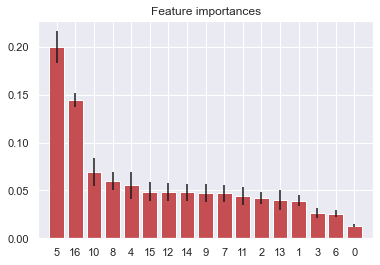

In [83]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_new.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_na.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_na.shape[1]), indices)
plt.xlim([-1, x_na.shape[1]])
plt.show()

## Step 6e: Feature selection as part of a pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(x_na, y_na)